In [1]:
#importing the required modules
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.patches import Rectangle
import numpy as np


In [2]:
# Set up a satellite map
Map = geemap.Map()
Map.add_basemap('SATELLITE')

In [3]:
# Load the GeoJSON file
geojson_path = "/scratch/du53/Seasonal Surface Water Variations/au.json"

# Load the GeoJSON file as a GeoDataFrame
gdf = gpd.read_file(geojson_path)

# Create a map using geemap
Map = geemap.Map(center=[-25, 135], zoom=4)

# Add the GeoDataFrame to the map
Map.add_gdf(gdf, layer_name="Australia Regions", style={'color': 'red', 'fillColor': 'blue', 'fillOpacity': 0.4})

# Display the map
Map.addLayerControl()
Map

Map(center=[-25, 135], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

In [4]:
# Create a map
Map = geemap.Map(center=[-35.5, 149], zoom=5)

# Filter GeoDataFrame to get specific regions (Victoria, New South Wales, ACT)
victoria_gdf = gdf[gdf['name'] == 'Victoria']
nsw_gdf = gdf[gdf['name'] == 'New South Wales']
act_gdf = gdf[gdf['name'] == 'Australian Capital Territory']

# Style dictionaries for different regions
victoria_style = {'color': 'red', 'fillColor': 'red', 'fillOpacity': 0.4}
nsw_style = {'color': 'blue', 'fillColor': 'blue', 'fillOpacity': 0.4}
act_style = {'color': 'green', 'fillColor': 'green', 'fillOpacity': 0.4}

# Add the layers to the map with corresponding styles
Map.add_gdf(victoria_gdf, layer_name="Victoria", style=victoria_style)
Map.add_gdf(nsw_gdf, layer_name="New South Wales", style=nsw_style)
Map.add_gdf(act_gdf, layer_name="ACT", style=act_style)

# Add map controls
Map.addLayerControl()

# Display the map
Map

Map(center=[-35.5, 149], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

The compiled code below outputs the size of the agricultural and irrigation areas per year from the years 2000 to the present.

In [8]:
# Convert the GeoDataFrame to an Earth Engine FeatureCollection
ee_fc = geemap.geopandas_to_ee(gdf)
victoria = ee_fc.filter(ee.Filter.eq('name', 'Victoria'))

# Merge all regions into one feature collection
regions = victoria

# Use the MODIS Land Cover dataset (2001 onwards)
modis_land_cover = ee.ImageCollection("MODIS/006/MCD12Q1")

In [9]:
# Function to calculate yearly agricultural area for a specific year
def calculate_yearly_agriculture(image_collection, region, year, scale=5000):
    # Filter the image collection for the specific year
    year_collection = image_collection.filterDate(f'{year}-01-01', f'{year}-12-31')
    
    def area_calculation(img):
        # Selecting the landcover type; class 12 and 14 refer to areas of agriculture and irrigation
        agriculture_mask = img.select('LC_Type1').eq(12).Or(img.select('LC_Type1').eq(14)) 
        agriculture_area = agriculture_mask.multiply(ee.Image.pixelArea()).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=region.geometry(),
            scale=scale,
            maxPixels=1e9,
            bestEffort=True
        ).get('LC_Type1')
        # Convert from square meters to square kilometres
        agriculture_area_sq_km = ee.Number(agriculture_area).divide(1e6)
        return ee.Feature(None, {
            'date': img.date().format('YYYY-MM'),
            'agriculture_area': agriculture_area_sq_km
        })

    # Map the function over the year collection and extract results 
    agriculture_area_collection = year_collection.map(area_calculation)

    # Convert to a list of dictionaries and get the data client-side
    agriculture_areas = agriculture_area_collection.reduceColumns(
        ee.Reducer.toList(2), ['date', 'agriculture_area']).get('list').getInfo()

    # Convert the list of dictionaries into a pandas DataFrame
    df = pd.DataFrame(agriculture_areas, columns=['date', 'agriculture_area'])
    df['date'] = pd.to_datetime(df['date'])
    return df


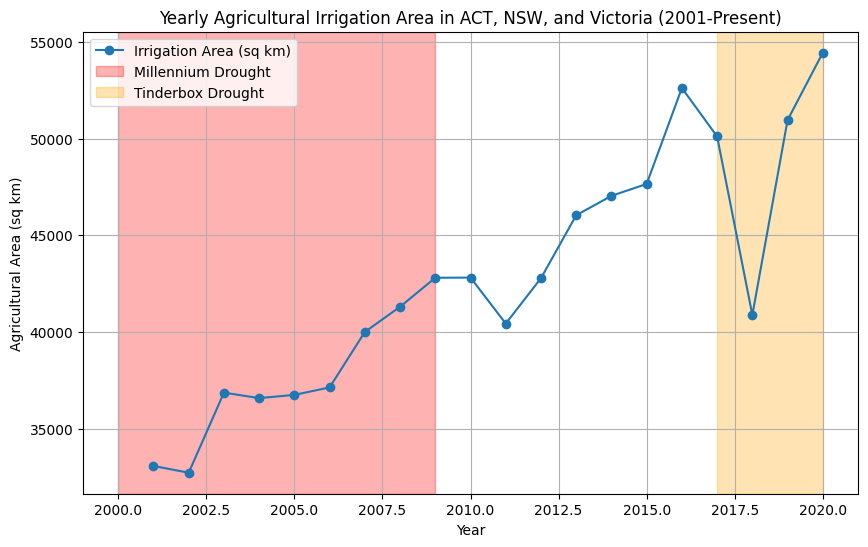

In [10]:
# Define the range of years (2000 to the present)
years = list(range(2000, 2024))  

# Calculate agricultural area for each year
yearly_agriculture_data = []
for year in years:
    df_year = calculate_yearly_agriculture(modis_land_cover, regions, year)
    yearly_agriculture_data.append(df_year)

# Concatenate the yearly data into a single DataFrame
all_years_data = pd.concat(yearly_agriculture_data)

# Group the data by year and calculate the total or average agricultural area for each year
all_years_data['year'] = all_years_data['date'].dt.year
yearly_agriculture = all_years_data.groupby('year').mean()

# Plot the yearly trend
plt.figure(figsize=(10, 6))

plt.plot(yearly_agriculture.index, yearly_agriculture['agriculture_area'], marker='o', label='Irrigation Area (sq km)')

# Highlight the Millennium Drought (2000-2009)
plt.axvspan(2000, 2009, color='red', alpha=0.3, label='Millennium Drought')

# Highlight the Tinderbox Drought (2017-2020)
plt.axvspan(2017, 2020, color='orange', alpha=0.3, label='Tinderbox Drought')

# Customize the plot
plt.title('Yearly Agricultural Irrigation Area in ACT, NSW, and Victoria (2001-Present)')
plt.xlabel('Year')
plt.ylabel('Agricultural Area (sq km)')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()


The following code outputs the yearly surface water area with the area of interest from the years 1990 onwards.

In [11]:
# Define the regions (Victoria, ACT, and NSW)
victoria = ee_fc.filter(ee.Filter.eq('name', 'Victoria'))
act = ee_fc.filter(ee.Filter.eq('name', 'Australian Capital Territory'))
nsw = ee_fc.filter(ee.Filter.eq('name', 'New South Wales'))

# Merge all regions into one feature collection
regions = victoria.merge(act).merge(nsw)

# Use the JRC Global Surface Water dataset (1984-present)
jrc_water = ee.ImageCollection("JRC/GSW1_4/MonthlyHistory")

In [12]:
# Define the range of years (1990 to present)
years = list(range(1990, 2024))

# Function to calculate the monthly surface water area for a specific year (in square kilometers)
def calculate_monthly_surface_water(image_collection, region, year, scale=5000):
    # Filter the image collection for the specific year
    year_collection = image_collection.filterDate(f'{year}-01-01', f'{year}-12-31').select('water')

    def area_calculation(img):
        # Only consider permanent water where value = 2 in the dataset
        water_mask = img.eq(2)
        water_area = water_mask.multiply(ee.Image.pixelArea()).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=region.geometry(),
            scale=scale,
            maxPixels=1e9,
            bestEffort=True
        ).get('water')
        # Convert from square meters to square kilometers
        water_area_sq_km = ee.Number(water_area).divide(1e6)
        return ee.Feature(None, {
            'date': img.date().format('YYYY-MM'),
            'water_area': water_area_sq_km
        })

    # Map the function over the year collection and extract results 
    water_area_collection = year_collection.map(area_calculation)

    # Convert to a list of dictionaries and get the data client-side
    water_areas = water_area_collection.reduceColumns(
        ee.Reducer.toList(2), ['date', 'water_area']).get('list').getInfo()

    # Convert the list of dictionaries into a pandas DataFrame
    df = pd.DataFrame(water_areas, columns=['date', 'water_area'])
    df['date'] = pd.to_datetime(df['date'])
    return df


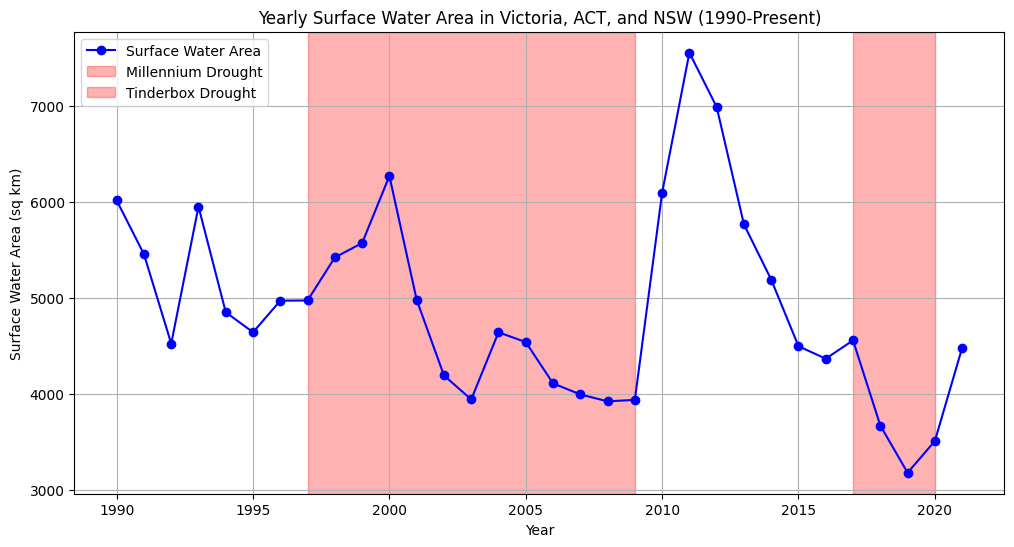

In [13]:
# Calculate surface water area for each year from 1990 to the present
all_years_data = []
for year in years:
    df_year = calculate_monthly_surface_water(jrc_water, regions, year)
    all_years_data.append(df_year)

# Combine all years' data into a single DataFrame
surface_water_time_series = pd.concat(all_years_data)

# Group the data by year and calculate the total or average surface water area for each year
surface_water_time_series['year'] = surface_water_time_series['date'].dt.year
yearly_surface_water = surface_water_time_series.groupby('year').mean()

# Define drought periods for highlighting
millennium_drought_start = 1997
millennium_drought_end = 2009
tinderbox_drought_start = 2017
tinderbox_drought_end = 2020

# Plot the time series of surface water area from 1990 to present
plt.figure(figsize=(12, 6))
plt.plot(yearly_surface_water.index, yearly_surface_water['water_area'], marker='o', color='blue', label='Surface Water Area')

# Highlight Millennium Drought (1997-2009) and Tinderbox Drought (2017-2020)
plt.axvspan(millennium_drought_start, millennium_drought_end, color='red', alpha=0.3, label='Millennium Drought')
plt.axvspan(tinderbox_drought_start, tinderbox_drought_end, color='red', alpha=0.3, label='Tinderbox Drought')

# Customize the plot
plt.title('Yearly Surface Water Area in Victoria, ACT, and NSW (1990-Present)')
plt.xlabel('Year')
plt.ylabel('Surface Water Area (sq km)')
plt.grid(True)
plt.legend()
plt.show()


The code below outputs two graphs; one graph showing a time series of the surface water area across the region of interest during the Millenium drought, the other during the Tinderbox drought.

In [21]:
# Function to calculate monthly surface water area for a specific year and month (in square kilometers)
def calculate_monthly_surface_water(image_collection, region, start_date, end_date, scale=5000):
    # Filter the image collection for the specified date range
    date_range_collection = image_collection.filterDate(start_date, end_date).select('water')

    def area_calculation(img):
        # Only consider permanent water (where value == 2 in the dataset)
        water_mask = img.eq(2)
        water_area = water_mask.multiply(ee.Image.pixelArea()).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=region.geometry(),
            scale=scale,
            maxPixels=1e9,
            bestEffort=True
        ).get('water')
        # Convert from square meters to square kilometers
        water_area_sq_km = ee.Number(water_area).divide(1e6)
        return ee.Feature(None, {
            'date': img.date().format('YYYY-MM'),
            'water_area': water_area_sq_km
        })

    # Map the function over the date range collection and extract results as a FeatureCollection
    water_area_collection = date_range_collection.map(area_calculation)

    # Convert the FeatureCollection to a list of dictionaries and get the data client-side
    water_areas = water_area_collection.reduceColumns(
        ee.Reducer.toList(2), ['date', 'water_area']).get('list').getInfo()

    # Convert the list of dictionaries into a pandas DataFrame
    df = pd.DataFrame(water_areas, columns=['date', 'water_area'])
    df['date'] = pd.to_datetime(df['date'])
    return df


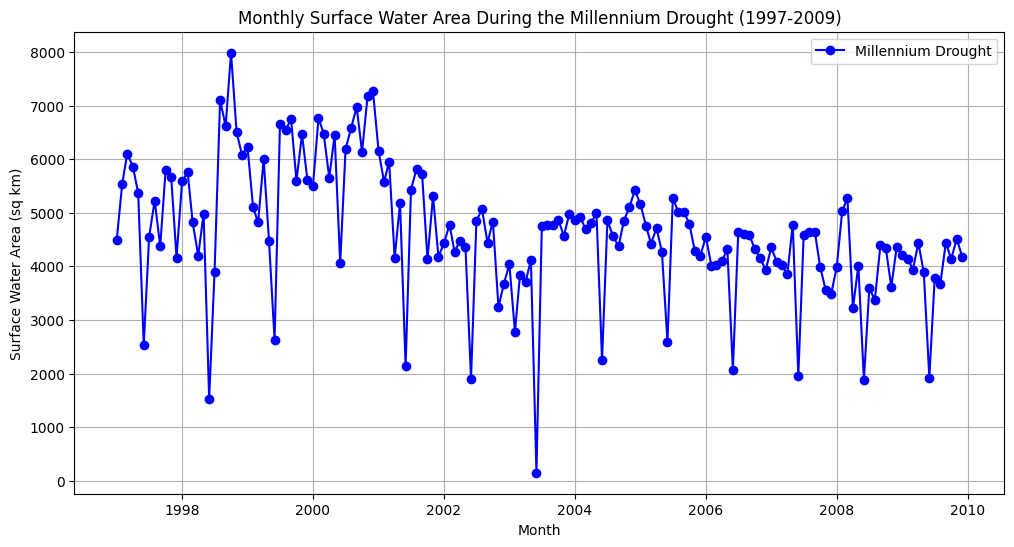

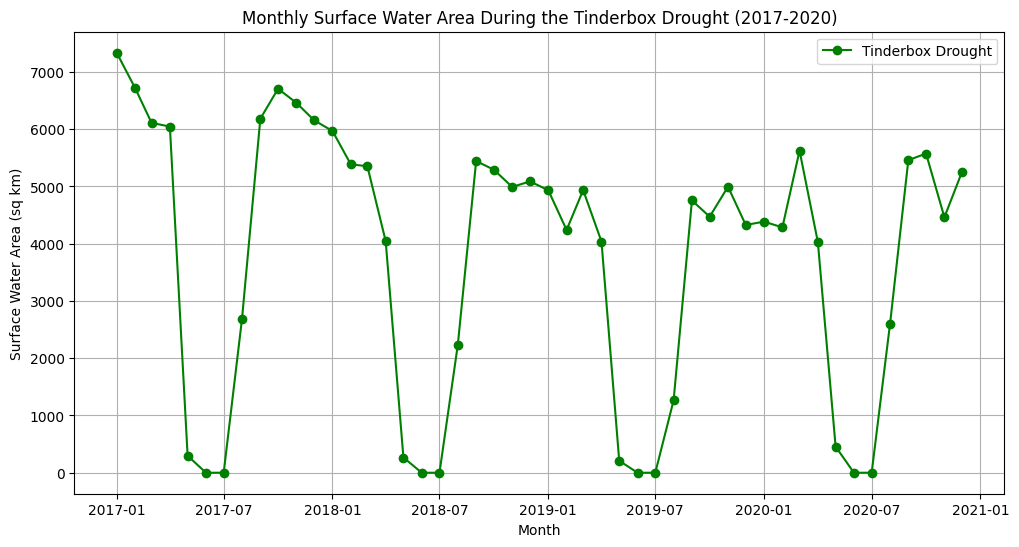

In [22]:
# Calculate monthly surface water area for the Millennium Drought (1997-2009) and Tinderbox Drought (2017-2020)
millennium_drought = calculate_monthly_surface_water(jrc_water, regions, '1997-01-01', '2009-12-31')
tinderbox_drought = calculate_monthly_surface_water(jrc_water, regions, '2017-01-01', '2020-12-31')

# Convert 'date' to datetime and extract year and month for aggregation
millennium_drought['month'] = millennium_drought['date'].dt.to_period('M')
tinderbox_drought['month'] = tinderbox_drought['date'].dt.to_period('M')

# Group by month and calculate average surface water area for each month
millennium_monthly_avg = millennium_drought.groupby('month').mean()
tinderbox_monthly_avg = tinderbox_drought.groupby('month').mean()

# Plot the Millennium Drought (1997-2009)
plt.figure(figsize=(12, 6))
plt.plot(millennium_monthly_avg.index.to_timestamp(), millennium_monthly_avg['water_area'], marker='o', color='blue', label='Millennium Drought')

# Customize the plot
plt.title('Monthly Surface Water Area During the Millennium Drought (1997-2009)')
plt.xlabel('Month')
plt.ylabel('Surface Water Area (sq km)')
plt.grid(True)
plt.legend()
plt.show()

# Plot the Tinderbox Drought (2017-2020)
plt.figure(figsize=(12, 6))
plt.plot(tinderbox_monthly_avg.index.to_timestamp(), tinderbox_monthly_avg['water_area'], marker='o', color='green', label='Tinderbox Drought')

# Customize the plot
plt.title('Monthly Surface Water Area During the Tinderbox Drought (2017-2020)')
plt.xlabel('Month')
plt.ylabel('Surface Water Area (sq km)')
plt.grid(True)
plt.legend()
plt.show()


The code below outputs the monthly surface water area across the area of interest from the years 1990 and onwards.

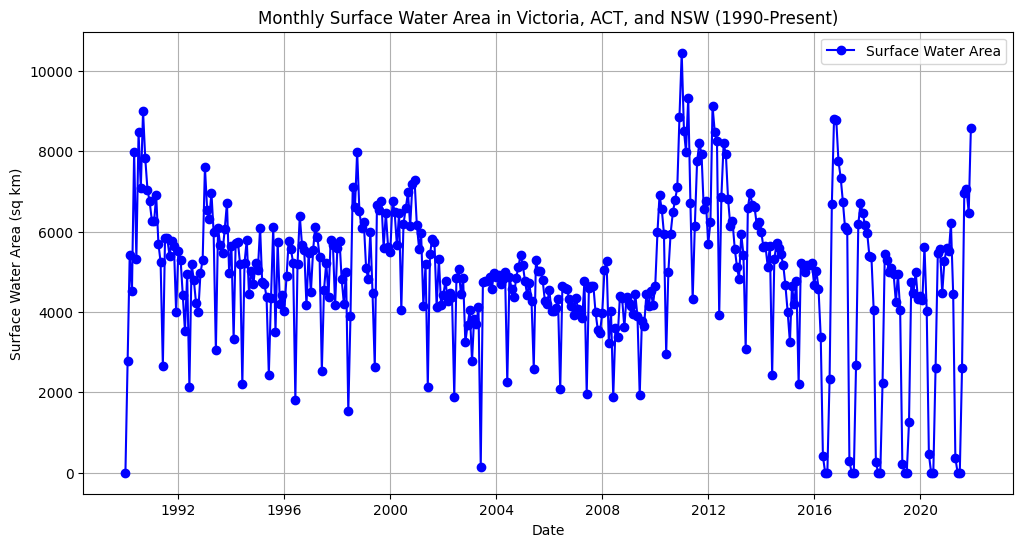

In [23]:
# Calculate surface water area for the period from 1990 to the present (monthly data)
monthly_surface_water = calculate_monthly_surface_water(jrc_water, regions, '1990-01-01', '2024-01-01')

# Convert 'date' to datetime and extract year and month for aggregation
monthly_surface_water['month'] = monthly_surface_water['date'].dt.to_period('M')

# Group by month and calculate average surface water area for each month
monthly_avg_water_area = monthly_surface_water.groupby('month').mean()

# Plot the monthly time series from 1990 to the present
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg_water_area.index.to_timestamp(), monthly_avg_water_area['water_area'], marker='o', color='blue', label='Surface Water Area')

# Customize the plot
plt.title('Monthly Surface Water Area in Victoria, ACT, and NSW (1990-Present)')
plt.xlabel('Date')
plt.ylabel('Surface Water Area (sq km)')
plt.grid(True)
plt.legend()
plt.show()

The code below outputs the monthly surface water area across the area of interest for the Millenium and Tinderbox Droughts. However, this also shows the average monthly surface area across both droughts; showing it as a straight gridded line.

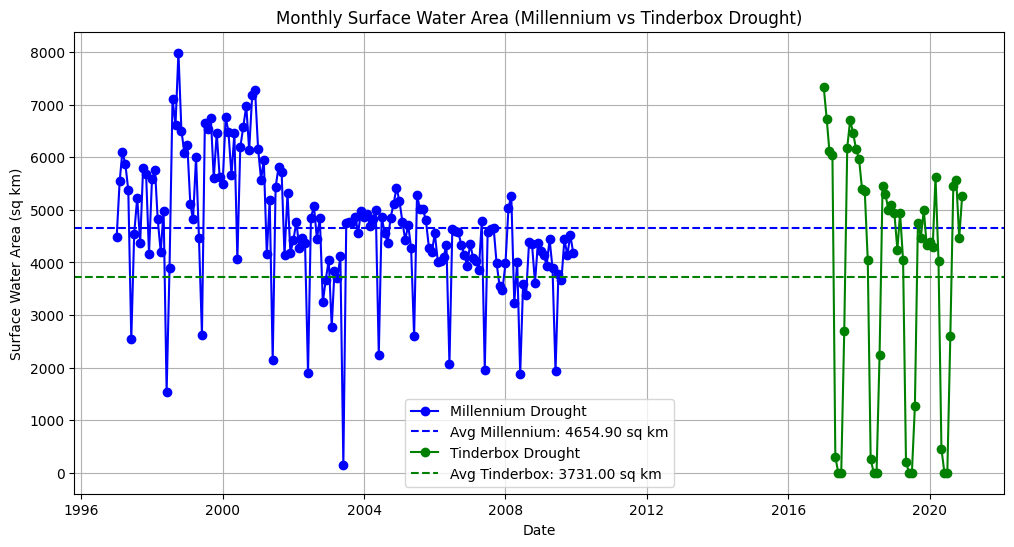

In [24]:
# Calculate monthly surface water area for the Millennium Drought (1997-2009) and Tinderbox Drought (2017-2020)
millennium_drought = calculate_monthly_surface_water(jrc_water, regions, '1997-01-01', '2009-12-31')
tinderbox_drought = calculate_monthly_surface_water(jrc_water, regions, '2017-01-01', '2020-12-31')

# Convert 'date' to datetime and extract year and month for aggregation
millennium_drought['month'] = millennium_drought['date'].dt.to_period('M')
tinderbox_drought['month'] = tinderbox_drought['date'].dt.to_period('M')

# Group by month and calculate average surface water area for each month
millennium_monthly_avg = millennium_drought.groupby('month').mean()
tinderbox_monthly_avg = tinderbox_drought.groupby('month').mean()

# Calculate overall average surface water area for both droughts
overall_avg_millennium = millennium_monthly_avg['water_area'].mean()
overall_avg_tinderbox = tinderbox_monthly_avg['water_area'].mean()

# First time series plot (all months of each drought)
plt.figure(figsize=(12, 6))
plt.plot(millennium_drought['date'], millennium_drought['water_area'], marker='o', color='blue', label='Millennium Drought')
plt.axhline(overall_avg_millennium, color='blue', linestyle='--', label=f'Avg Millennium: {overall_avg_millennium:.2f} sq km')

plt.plot(tinderbox_drought['date'], tinderbox_drought['water_area'], marker='o', color='green', label='Tinderbox Drought')
plt.axhline(overall_avg_tinderbox, color='green', linestyle='--', label=f'Avg Tinderbox: {overall_avg_tinderbox:.2f} sq km')

# Customize the plot
plt.title('Monthly Surface Water Area (Millennium vs Tinderbox Drought)')
plt.xlabel('Date')
plt.ylabel('Surface Water Area (sq km)')
plt.grid(True)
plt.legend()
plt.show()


The code below outputs a time series of the surface water area across the area of interest from the years 1990 onwards. The Millenium and Tinderbox Droughts are highlighted in red rectangles to highlight the difference in patterns compared to non-drought years. Furthermore, there are also calculations of the overall surface water area averages inclusive of drought years, averages for the respective droughts, and finally a calculation of the average surface water area outside of the drought years. These are shown within the graphs as dotted lines. The calculated values for each are shown in the legend of the graphs.

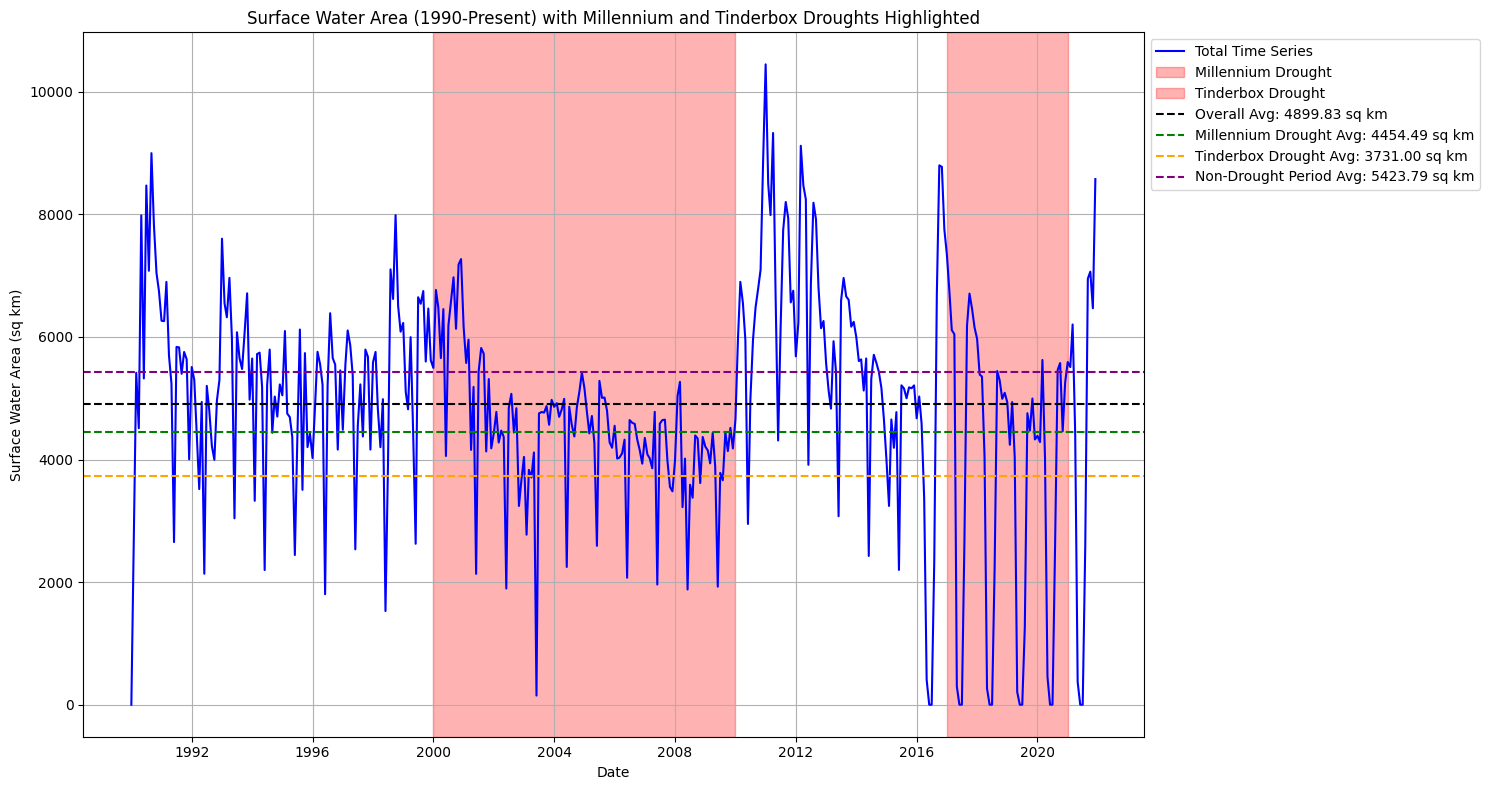

In [26]:
# Calculate monthly surface water area for the full dataset (1990-present)
full_time_series = calculate_monthly_surface_water(jrc_water, regions, '1990-01-01', '2023-12-31')

# Calculate monthly surface water area for the Millennium Drought (2000-2009)
millennium_drought = calculate_monthly_surface_water(jrc_water, regions, '2000-01-01', '2009-12-31')

# Calculate monthly surface water area for the Tinderbox Drought (2017-2020)
tinderbox_drought = calculate_monthly_surface_water(jrc_water, regions, '2017-01-01', '2020-12-31')

# Calculate the average surface water area for the entire time series, Millennium Drought, and Tinderbox Drought
overall_avg_water_area = full_time_series['water_area'].mean()
millennium_avg_water_area = millennium_drought['water_area'].mean()
tinderbox_avg_water_area = tinderbox_drought['water_area'].mean()

# Filter out the periods not in the Millennium or Tinderbox Drought
non_drought_periods = full_time_series[
    ~((full_time_series['date'] >= pd.Timestamp('1997-01-01')) & (full_time_series['date'] <= pd.Timestamp('2009-12-31'))) &
    ~((full_time_series['date'] >= pd.Timestamp('2017-01-01')) & (full_time_series['date'] <= pd.Timestamp('2020-12-31')))
]

# Calculate the average water surface area for the periods outside of the two droughts
non_drought_avg_water_area = non_drought_periods['water_area'].mean()

# Plot the full time series
plt.figure(figsize=(15, 8))

# Plot the water surface area over time
plt.plot(full_time_series['date'], full_time_series['water_area'], color='blue', label='Total Time Series')

# Highlight the Millennium Drought (2000-2009) and Tinderbox Drought (2017-2020)
plt.axvspan(pd.Timestamp('2000-01-01'), pd.Timestamp('2009-12-31'), color='red', alpha=0.3, label='Millennium Drought')
plt.axvspan(pd.Timestamp('2017-01-01'), pd.Timestamp('2020-12-31'), color='red', alpha=0.3, label='Tinderbox Drought')

# Plot the average water surface area for the entire time series, Millennium Drought, Tinderbox Drought, and non-drought periods
plt.axhline(overall_avg_water_area, color='black', linestyle='--', label=f'Overall Avg: {overall_avg_water_area:.2f} sq km')
plt.axhline(millennium_avg_water_area, color='green', linestyle='--', label=f'Millennium Drought Avg: {millennium_avg_water_area:.2f} sq km')
plt.axhline(tinderbox_avg_water_area, color='orange', linestyle='--', label=f'Tinderbox Drought Avg: {tinderbox_avg_water_area:.2f} sq km')
plt.axhline(non_drought_avg_water_area, color='purple', linestyle='--', label=f'Non-Drought Period Avg: {non_drought_avg_water_area:.2f} sq km')

# Customize the plot
plt.title('Surface Water Area (1990-Present) with Millennium and Tinderbox Droughts Highlighted')
plt.xlabel('Date')
plt.ylabel('Surface Water Area (sq km)')
plt.grid(True)

# Move the legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust the layout to fit the legend
plt.tight_layout()

# Show the plot
plt.show()


The code below shows a graph of surface water averages across different seasons for the years of the Millenium and Tinderbox droughts. 

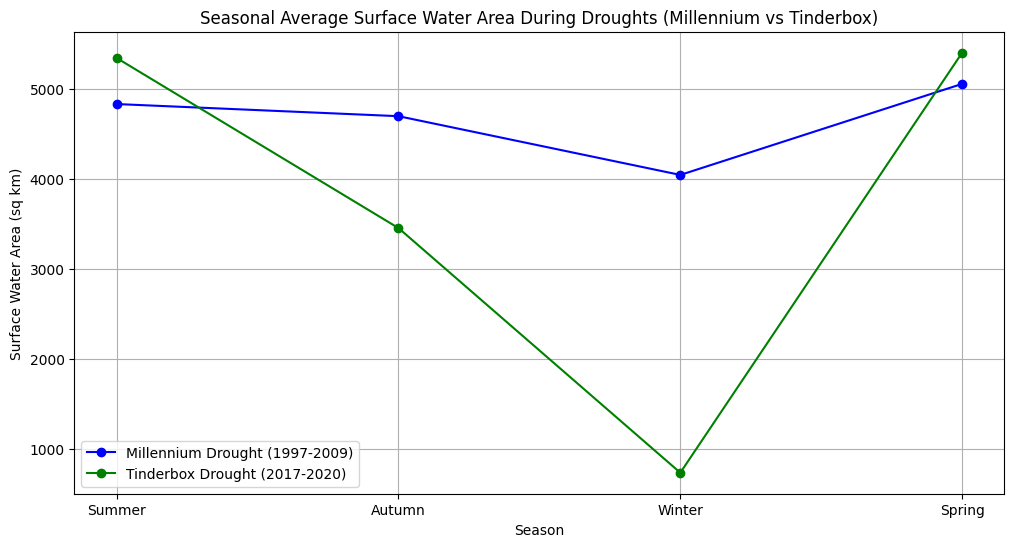

In [27]:
# Calculate monthly surface water area for the Millennium Drought (1997-2009)
millennium_drought = calculate_monthly_surface_water(jrc_water, regions, '1997-01-01', '2009-12-31')

# Calculate monthly surface water area for the Tinderbox Drought (2017-2020)
tinderbox_drought = calculate_monthly_surface_water(jrc_water, regions, '2017-01-01', '2020-12-31')

# Define a function to map months to seasons in Australia
def get_season(month):
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    elif month in [9, 10, 11]:
        return 'Spring'

# Add a 'season' column to both drought dataframes
millennium_drought['season'] = millennium_drought['date'].dt.month.apply(get_season)
tinderbox_drought['season'] = tinderbox_drought['date'].dt.month.apply(get_season)

# Group the data by season and calculate the average water surface area for each season
millennium_seasonal_avg = millennium_drought.groupby('season').mean()
tinderbox_seasonal_avg = tinderbox_drought.groupby('season').mean()

# Create a categorical index for seasons to ensure they are plotted in the correct order
season_order = ['Summer', 'Autumn', 'Winter', 'Spring']
millennium_seasonal_avg = millennium_seasonal_avg.reindex(season_order)
tinderbox_seasonal_avg = tinderbox_seasonal_avg.reindex(season_order)

# Plot the seasonal averages for both droughts
plt.figure(figsize=(12, 6))
plt.plot(millennium_seasonal_avg.index, millennium_seasonal_avg['water_area'], marker='o', color='blue', label='Millennium Drought (1997-2009)')
plt.plot(tinderbox_seasonal_avg.index, tinderbox_seasonal_avg['water_area'], marker='o', color='green', label='Tinderbox Drought (2017-2020)')

# Customize the plot
plt.title('Seasonal Average Surface Water Area During Droughts (Millennium vs Tinderbox)')
plt.xlabel('Season')
plt.ylabel('Surface Water Area (sq km)')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


The code below shows the seasonal average surface water data during each of the droughts. However it also shows the full average surface water area, Millenium Drought surface water area and Tinderbox surface water area. The data is presented as bar graphs as well for easy comparison between seasons.

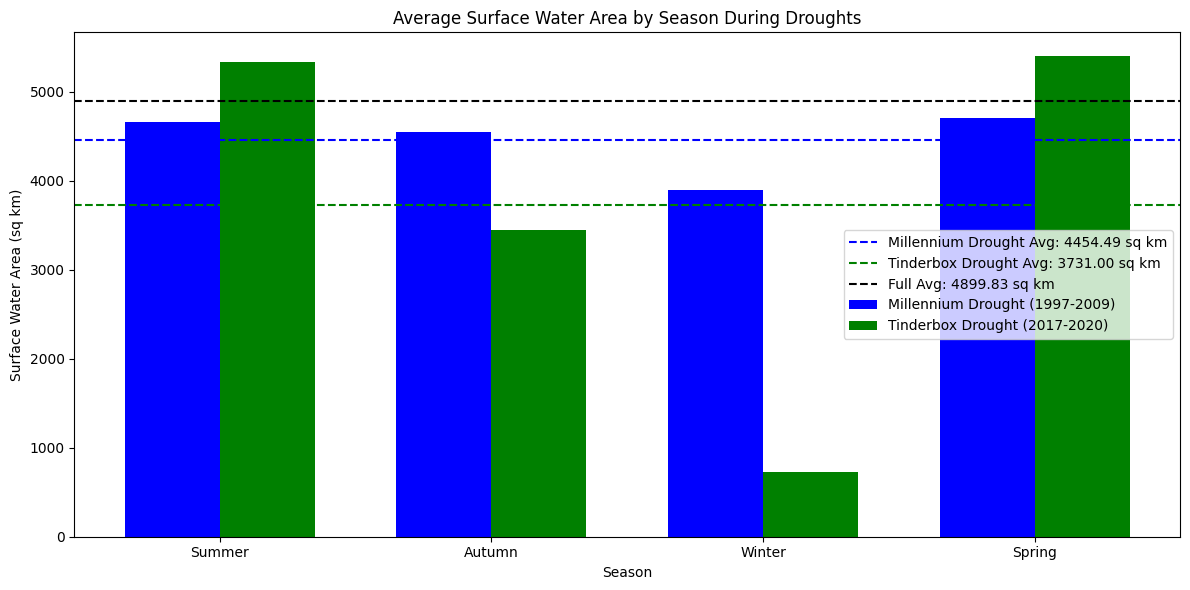

In [29]:
# Calculate monthly surface water area for the Millennium Drought (2000-2009)
millennium_drought = calculate_monthly_surface_water(jrc_water, regions, '2000-01-01', '2009-12-31')

# Calculate monthly surface water area for the Tinderbox Drought (2017-2020)
tinderbox_drought = calculate_monthly_surface_water(jrc_water, regions, '2017-01-01', '2020-12-31')

# Calculate the full time series average (1990-present)
full_time_series = calculate_monthly_surface_water(jrc_water, regions, '1990-01-01', '2023-12-31')

# Define a function to map months to seasons in Australia
def get_season(month):
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    elif month in [9, 10, 11]:
        return 'Spring'

# Add a 'season' column to both drought dataframes
millennium_drought['season'] = millennium_drought['date'].dt.month.apply(get_season)
tinderbox_drought['season'] = tinderbox_drought['date'].dt.month.apply(get_season)

# Group the data by season and calculate the average water surface area for each season
millennium_seasonal_avg = millennium_drought.groupby('season').mean()
tinderbox_seasonal_avg = tinderbox_drought.groupby('season').mean()

# Reindex the seasonal data to ensure correct seasonal order
season_order = ['Summer', 'Autumn', 'Winter', 'Spring']
millennium_seasonal_avg = millennium_seasonal_avg.reindex(season_order)
tinderbox_seasonal_avg = tinderbox_seasonal_avg.reindex(season_order)

# Calculate the average water surface area for the duration of each drought and the full time period
millennium_avg_water_area = millennium_drought['water_area'].mean()
tinderbox_avg_water_area = tinderbox_drought['water_area'].mean()
full_avg_water_area = full_time_series['water_area'].mean()

# Create a bar plot
x = np.arange(len(season_order))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Bar plots for each drought
rects1 = ax.bar(x - width/2, millennium_seasonal_avg['water_area'], width, label='Millennium Drought (1997-2009)', color='blue')
rects2 = ax.bar(x + width/2, tinderbox_seasonal_avg['water_area'], width, label='Tinderbox Drought (2017-2020)', color='green')

# Plot average lines
ax.axhline(millennium_avg_water_area, color='blue', linestyle='--', label=f'Millennium Drought Avg: {millennium_avg_water_area:.2f} sq km')
ax.axhline(tinderbox_avg_water_area, color='green', linestyle='--', label=f'Tinderbox Drought Avg: {tinderbox_avg_water_area:.2f} sq km')
ax.axhline(full_avg_water_area, color='black', linestyle='--', label=f'Full Avg: {full_avg_water_area:.2f} sq km')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Season')
ax.set_ylabel('Surface Water Area (sq km)')
ax.set_title('Average Surface Water Area by Season During Droughts')
ax.set_xticks(x)
ax.set_xticklabels(season_order)
ax.legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


The code below outputs a map overlooking the area of interest. The permanent surface water on the map is highlighted in red. A timeslider has been added for the years of 2017 to 2020; around the time of the tinderbox drought.

In [14]:

# Create a map centered on the area of interest
Map = geemap.Map(center=[-35, 150], zoom=5)

# Global Surface Water Dataset - Monthly Data focused on Tinderbox Drought period (2017-2020)
gsw = ee.ImageCollection('JRC/GSW1_4/MonthlyHistory').filterDate('2017-01-01', '2020-12-31')

# Define a function to clip and mask non-water pixels (only keep water pixels)
def process_image(img):
    water_mask = img.select('water').eq(2)  # 2 indicates permanent water
    return img.updateMask(water_mask).clip(regions)

# Apply the processing function to each image in the collection
gsw_processed = gsw.map(process_image)

# Define visualization parameters for surface water (bright red)
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['000000', 'FF0000']  # Bright red for water
}

# Add surface water layer with a time slider (2017-2020) using monthly data
Map.add_time_slider(gsw_processed.select('water'), vis_params, time_interval=1, layer_name='Surface Water Evolution (Tinderbox Drought)')

# Function to mask clouds using the Sentinel-2 QA60 band
def mask_s2_clouds(image):
    # Select the QA60 band
    qa = image.select('QA60')
    # Bit 10 and 11 represent clouds and cirrus clouds respectively
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    # Mask both clouds and cirrus clouds
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    return image.updateMask(mask).divide(10000)  # Scale the image to the range [0,1]

# Add a Sentinel-2 image layer (e.g., for context) with cloud masking applied
sentinel = ee.ImageCollection('COPERNICUS/S2').filterDate('2020-01-01', '2020-12-31') \
    .filterBounds(regions) \
    .map(mask_s2_clouds) \
    .median() \
    .clip(regions)

# Add the masked Sentinel-2 layer to the map
Map.addLayer(sentinel, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, 'Cloud-Free Sentinel-2 Image')

# Display the map
Map.addLayerControl()
Map


Map(center=[-35, 150], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

In [15]:

# Create a map centered on the area of interest
Map = geemap.Map(center=[-35, 150], zoom=5)

# Define a function to clip and mask non-water pixels (only keep water pixels)
def process_image(img):
    water_mask = img.select('water').eq(2)  # 2 indicates permanent water
    return img.updateMask(water_mask).clip(regions)

# Apply the processing function to each image in the collection
gsw_processed = gsw.map(process_image)

# Define visualization parameters for surface water (bright red)
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['000000', 'FF0000']  # Bright red for water
}

# Add surface water layer with a time slider (2017-2020) using monthly data
Map.add_time_slider(gsw_processed.select('water'), vis_params, time_interval=1, layer_name='Surface Water Evolution (Tinderbox Drought)')

# Function to mask clouds using the Sentinel-2 QA60 band
def mask_s2_clouds(image):
    # Select the QA60 band
    qa = image.select('QA60')
    # Bit 10 and 11 represent clouds and cirrus clouds respectively
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    # Mask both clouds and cirrus clouds
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    return image.updateMask(mask).divide(10000)  # Scale the image to the range [0,1]

# Add a Sentinel-2 image layer (e.g., for context) with cloud masking applied
sentinel = ee.ImageCollection('COPERNICUS/S2').filterDate('2020-01-01', '2020-12-31') \
    .filterBounds(regions) \
    .map(mask_s2_clouds) \
    .median() \
    .clip(regions)

# Add the masked Sentinel-2 layer to the map
Map.addLayer(sentinel, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, 'Cloud-Free Sentinel-2 Image')

# Display the map
Map.addLayerControl()
Map


Map(center=[-35, 150], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

The code below outputs a map overlooking the area of interest. The permanent surface water on the map is highlighted in red. Outputs a gif of surface water from the years 1990 until 2020.

In [16]:
# Create a map centered on the area of interest
Map = geemap.Map(center=[-35, 150], zoom=5)

# Global Surface Water Dataset - Monthly Data 
gsw = ee.ImageCollection('JRC/GSW1_4/MonthlyHistory').filterDate('1990-01-01', '2020-12-31')

# Define a function to clip and mask non-water pixels (only keep water pixels)
def process_image(img):
    water_mask = img.select('water').eq(2)  # 2 indicates permanent water
    return img.updateMask(water_mask).clip(regions)

# Apply the processing function to each image in the collection
gsw_processed = gsw.map(process_image)

# Group by month using the first day of each month and reduce the images to monthly means
gsw_monthly = ee.ImageCollection(gsw_processed).map(lambda img: img.set('system:time_start', ee.Date(img.get('system:time_start')).get('month')))
gsw_monthly = gsw_processed.filter(ee.Filter.calendarRange(1, 12, 'month'))

# Define visualization parameters for surface water (bright red)
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['000000', 'FF0000']  # Bright red for water
}

# Function to mask clouds using the Sentinel-2 QA60 band
def mask_s2_clouds(image):
    # Select the QA60 band
    qa = image.select('QA60')
    # Bit 10 and 11 represent clouds and cirrus clouds respectively
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    # Mask both clouds and cirrus clouds
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    return image.updateMask(mask).divide(10000)  # Scale the image to the range [0,1]

# Add a Sentinel-2 image layer (e.g., for context) with cloud masking applied
sentinel = ee.ImageCollection('COPERNICUS/S2').filterDate('1990-01-01', '2020-12-31') \
    .filterBounds(regions) \
    .map(mask_s2_clouds) \
    .median() \
    .clip(regions)

# Add the masked Sentinel-2 layer to the map
Map.addLayer(sentinel, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, 'Cloud-Free Sentinel-2 Image')

# Set the output path for the GIF
out_gif = 'scratch/du53/Seasonal Surface Water Variations/Monthly_Surface_Water_Timelapse.gif'

# Create the monthly time-lapse GIF of water surface changes
geemap.create_timelapse(
    gsw_processed.select('water'),
    start_date='1990-01-01',
    end_date='2020-12-31',
    region=regions.geometry(),
    out_gif=out_gif,
    vis_params=vis_params,
    frames_per_second=2,  # Slower frame rate to see monthly changes more clearly
    dimensions=500
)

# Display the map (optional, for interaction)
Map.addLayerControl()
Map

# Optionally, display the GIF in the notebook (if supported)
geemap.show_image(out_gif)


Generating URL...
Please wait ...
The GIF image has been saved to: /home/198/di6156/scratch/du53/Seasonal Surface Water Variations/scratch/du53/Seasonal Surface Water Variations/Monthly_Surface_Water_Timelapse.gif
ffmpeg is not installed on your computer.


Output()

The code below outputs a gif of a satellite image over the area of interest from the years 2015 to 2023.

In [17]:

# Load the Landsat 7 dataset from 2010 to the present, selecting one image per month
dataset = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2').filterDate('2015-01-01', '2023-10-01') \
    .filterBounds(regions.geometry()) \
    .filter(ee.Filter.calendarRange(1, 12, 'month')).select(['SR_B1', 'SR_B2', 'SR_B3', 'ST_B6', 'QA_PIXEL'])

# Function to apply scale factors to Landsat 7 images
def apply_scale_factors(image):
    # Scale optical bands SR_B1, SR_B2, SR_B3 and thermal band ST_B6
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermal_bands = image.select('ST_B6').multiply(0.00341802).add(149.0)
    # Combine scaled bands
    return image.addBands(optical_bands, None, True).addBands(thermal_bands, None, True)

# Function to mask clouds using the QA_PIXEL band
def mask_clouds(image):
    # Select the QA_PIXEL band
    qa = image.select('QA_PIXEL')
    # Create a mask for cloud bits 
    cloud_mask = qa.bitwiseAnd(1 << 3).eq(0)  # Cloud bit
    cloud_shadow_mask = qa.bitwiseAnd(1 << 4).eq(0)  # Cloud shadow bit
    # Combine cloud and shadow masks
    mask = cloud_mask.And(cloud_shadow_mask)
    # Apply the mask to the image
    return image.updateMask(mask)

# Apply scaling factors and cloud masking to the dataset
processed_dataset = dataset.map(apply_scale_factors).map(mask_clouds)

# Visualization parameters for true-color imagery 
visualization_params = {
    'bands': ['SR_B3', 'SR_B2', 'SR_B1'],  
    'min': 0.0,
    'max': 0.3, 
}

# Define the output GIF path
out_gif = '/scratch/du53/Seasonal Surface Water Variations/Satellite_Timelapse_CloudFree_Zoomed.gif'

# Create the time-lapse GIF using the dataset and zoomed region
geemap.create_timelapse(
    processed_dataset,
    start_date='2010-01-01',
    end_date='2024-10-01',
    region=regions.geometry(),  # Zooming in on the specific regions
    out_gif=out_gif,
    vis_params=visualization_params,
    frames_per_second=5,  # Speed of the GIF 
    dimensions=500  # Resolution of the GIF 
)

# display the GIF in the notebook 
geemap.show_image(out_gif)

Generating URL...
Please wait ...
The GIF image has been saved to: /scratch/du53/Seasonal Surface Water Variations/Satellite_Timelapse_CloudFree_Zoomed.gif
ffmpeg is not installed on your computer.


Output()

In [19]:
# Global Surface Water Dataset
gsw = ee.ImageCollection('JRC/GSW1_4/YearlyHistory')

# Define a function to calculate surface water area (in square kilometers)
def calculate_surface_water(img, region):
    water_mask = img.select('waterClass').eq(2)  # Permanent water = 2
    water_area = water_mask.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=region.geometry(),
        scale=5000,
        maxPixels=1e9
    ).get('waterClass')
    
    # Convert area from square meters to square kilometers
    return ee.Number(water_area).divide(1e6)

# Millennium Drought Period (2001-2009)
millennium_drought = gsw.filterDate('2001-01-01', '2009-12-31')

# Tinderbox Drought Period (2017-2020)
tinderbox_drought = gsw.filterDate('2017-01-01', '2020-12-31')

# Function to extract surface water area per year
def get_surface_water_per_year(image_collection, region):
    def calculate_yearly_water(img):
        water_area = calculate_surface_water(img, region)
        return img.set('year', img.date().format('YYYY')).set('water_area_km2', water_area)
    
    # Apply the function to the image collection
    water_years = image_collection.map(calculate_yearly_water)
    
    # Extract data into a list of dictionaries
    water_data = water_years.reduceColumns(ee.Reducer.toList(2), ['year', 'water_area_km2']).get('list').getInfo()
    
    # Convert to pandas DataFrame
    df = pd.DataFrame(water_data, columns=['year', 'water_area_km2'])
    df['year'] = pd.to_numeric(df['year'])
    return df


In [20]:
# Get surface water data for the Millennium Drought
millennium_water_data = get_surface_water_per_year(millennium_drought, regions)

# Get surface water data for the Tinderbox Drought
tinderbox_water_data = get_surface_water_per_year(tinderbox_drought, regions)

# Combine data for plotting and analysis
combined_data = pd.concat([millennium_water_data, tinderbox_water_data], ignore_index=True)

# Find the best and worst years for each drought
millennium_best_year = millennium_water_data.loc[millennium_water_data['water_area_km2'].idxmax()]
millennium_worst_year = millennium_water_data.loc[millennium_water_data['water_area_km2'].idxmin()]

tinderbox_best_year = tinderbox_water_data.loc[tinderbox_water_data['water_area_km2'].idxmax()]
tinderbox_worst_year = tinderbox_water_data.loc[tinderbox_water_data['water_area_km2'].idxmin()]

# Output the best and worst years
print("Millennium Drought:")
print(f"Best Year: {millennium_best_year['year']} (Surface Water: {millennium_best_year['water_area_km2']} km²)")
print(f"Worst Year: {millennium_worst_year['year']} (Surface Water: {millennium_worst_year['water_area_km2']} km²)")

print("\nTinderbox Drought:")
print(f"Best Year: {tinderbox_best_year['year']} (Surface Water: {tinderbox_best_year['water_area_km2']} km²)")
print(f"Worst Year: {tinderbox_worst_year['year']} (Surface Water: {tinderbox_worst_year['water_area_km2']} km²)")

Millennium Drought:
Best Year: 2007.0 (Surface Water: 3441.64289085482 km²)
Worst Year: 2002.0 (Surface Water: 2260.257459639195 km²)

Tinderbox Drought:
Best Year: 2020.0 (Surface Water: 4818.911488964458 km²)
Worst Year: 2018.0 (Surface Water: 2100.4672036078823 km²)


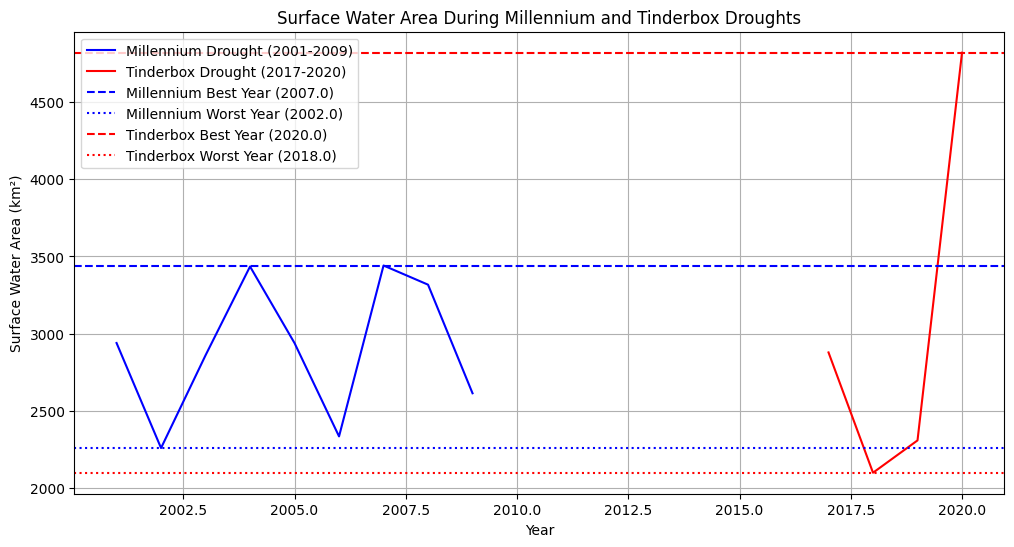

In [21]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(millennium_water_data['year'], millennium_water_data['water_area_km2'], label='Millennium Drought (2001-2009)', color='blue')
plt.plot(tinderbox_water_data['year'], tinderbox_water_data['water_area_km2'], label='Tinderbox Drought (2017-2020)', color='red')
plt.axhline(y=millennium_best_year['water_area_km2'], color='blue', linestyle='--', label=f"Millennium Best Year ({millennium_best_year['year']})")
plt.axhline(y=millennium_worst_year['water_area_km2'], color='blue', linestyle=':', label=f"Millennium Worst Year ({millennium_worst_year['year']})")
plt.axhline(y=tinderbox_best_year['water_area_km2'], color='red', linestyle='--', label=f"Tinderbox Best Year ({tinderbox_best_year['year']})")
plt.axhline(y=tinderbox_worst_year['water_area_km2'], color='red', linestyle=':', label=f"Tinderbox Worst Year ({tinderbox_worst_year['year']})")

# Customize the plot
plt.title('Surface Water Area During Millennium and Tinderbox Droughts')
plt.xlabel('Year')
plt.ylabel('Surface Water Area (km²)')
plt.grid(True)
plt.legend()
plt.show()

In [22]:
# Get surface water data for the full time period (1984-present)
full_water_data = get_surface_water_per_year(gsw, regions)

# Filter data for the Millennium and Tinderbox Droughts
millennium_water_data = full_water_data[(full_water_data['year'] >= 2001) & (full_water_data['year'] <= 2009)]
tinderbox_water_data = full_water_data[(full_water_data['year'] >= 2017) & (full_water_data['year'] < 2020)]

# Find the best and worst years for each drought
millennium_best_year = millennium_water_data.loc[millennium_water_data['water_area_km2'].idxmax()]
millennium_worst_year = millennium_water_data.loc[millennium_water_data['water_area_km2'].idxmin()]

tinderbox_best_year = tinderbox_water_data.loc[tinderbox_water_data['water_area_km2'].idxmax()]
tinderbox_worst_year = tinderbox_water_data.loc[tinderbox_water_data['water_area_km2'].idxmin()]

# Output the best and worst years
print("Millennium Drought:")
print(f"Best Year: {millennium_best_year['year']} (Surface Water: {millennium_best_year['water_area_km2']} km²)")
print(f"Worst Year: {millennium_worst_year['year']} (Surface Water: {millennium_worst_year['water_area_km2']} km²)")

print("\nTinderbox Drought:")
print(f"Best Year: {tinderbox_best_year['year']} (Surface Water: {tinderbox_best_year['water_area_km2']} km²)")
print(f"Worst Year: {tinderbox_worst_year['year']} (Surface Water: {tinderbox_worst_year['water_area_km2']} km²)")

Millennium Drought:
Best Year: 2007.0 (Surface Water: 3441.64289085482 km²)
Worst Year: 2002.0 (Surface Water: 2260.257459639195 km²)

Tinderbox Drought:
Best Year: 2017.0 (Surface Water: 2879.0579203372313 km²)
Worst Year: 2018.0 (Surface Water: 2100.4672036078823 km²)


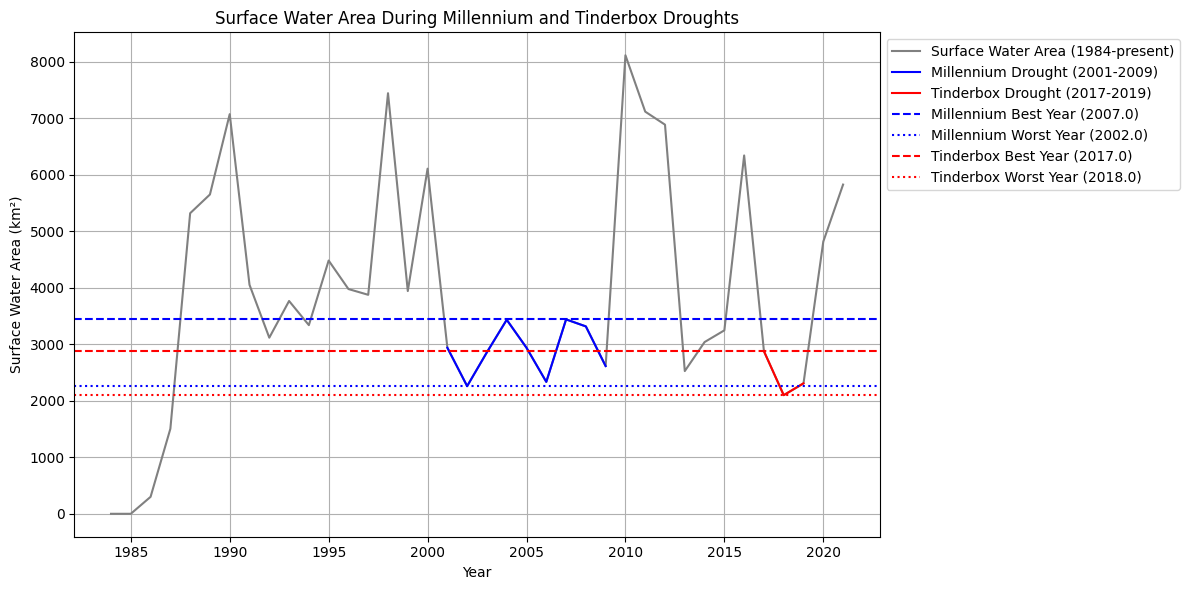

In [23]:
# Plot the data
plt.figure(figsize=(12, 6))

# Plot the full time series
plt.plot(full_water_data['year'], full_water_data['water_area_km2'], label='Surface Water Area (1984-present)', color='gray')

# Plot the Millennium Drought data
plt.plot(millennium_water_data['year'], millennium_water_data['water_area_km2'], label='Millennium Drought (2001-2009)', color='blue')

# Plot the Tinderbox Drought data
plt.plot(tinderbox_water_data['year'], tinderbox_water_data['water_area_km2'], label='Tinderbox Drought (2017-2019)', color='red')

# Highlight best and worst years
plt.axhline(y=millennium_best_year['water_area_km2'], color='blue', linestyle='--', label=f"Millennium Best Year ({millennium_best_year['year']})")
plt.axhline(y=millennium_worst_year['water_area_km2'], color='blue', linestyle=':', label=f"Millennium Worst Year ({millennium_worst_year['year']})")
plt.axhline(y=tinderbox_best_year['water_area_km2'], color='red', linestyle='--', label=f"Tinderbox Best Year ({tinderbox_best_year['year']})")
plt.axhline(y=tinderbox_worst_year['water_area_km2'], color='red', linestyle=':', label=f"Tinderbox Worst Year ({tinderbox_worst_year['year']})")

# Customize the plot
plt.title('Surface Water Area During Millennium and Tinderbox Droughts')
plt.xlabel('Year')
plt.ylabel('Surface Water Area (km²)')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move the legend outside the plot
plt.tight_layout()
plt.show()


The following code outputs a graph of yearly wheat production within Australia itself from 2001 to 2024.

In [24]:
# Load the uploaded CSV file to inspect the data
file_path = '/scratch/du53/Seasonal Surface Water Variations/FAOSTAT_data_en_10-20-2024.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,36,Australia,5510,Production,111,Wheat,2001,2001,t,22108000.0,A,Official figure,NaN
1,QCL,Crops and livestock products,36,Australia,5510,Production,111,Wheat,2002,2002,t,24299335.0,A,Official figure,NaN
2,QCL,Crops and livestock products,36,Australia,5510,Production,111,Wheat,2003,2003,t,10131924.0,A,Official figure,NaN
3,QCL,Crops and livestock products,36,Australia,5510,Production,111,Wheat,2004,2004,t,26131870.0,A,Official figure,NaN
4,QCL,Crops and livestock products,36,Australia,5510,Production,111,Wheat,2005,2005,t,21905113.0,A,Official figure,NaN


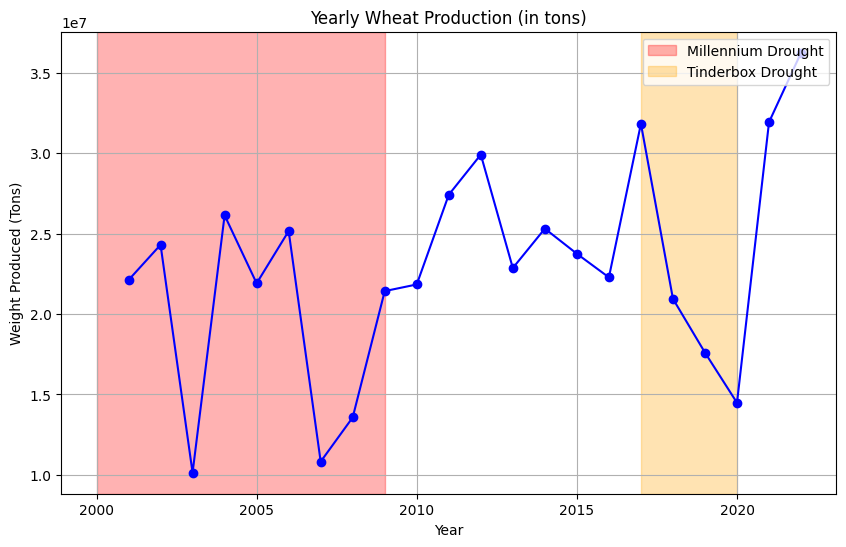

In [25]:
# Filter the data to get the relevant columns: Year and Production Value
filtered_data = data[['Year', 'Value']]

# Group by year and sum the production values (in case there are multiple entries for the same year)
yearly_production = filtered_data.groupby('Year')['Value'].sum()

# Plotting the graph
plt.figure(figsize=(10, 6))

# Plot the yearly production
plt.plot(yearly_production.index, yearly_production.values, marker='o', linestyle='-', color='b')

# Highlight the Millennium Drought (2000-2009)
plt.axvspan(2000, 2009, color='red', alpha=0.3, label='Millennium Drought')

# Highlight the Tinderbox Drought (2017-2020)
plt.axvspan(2017, 2020, color='orange', alpha=0.3, label='Tinderbox Drought')

# Add labels and title
plt.title('Yearly Wheat Production (in tons)')
plt.xlabel('Year')
plt.ylabel('Weight Produced (Tons)')
plt.grid(True)

# Add a legend to indicate the drought periods
plt.legend(loc='upper right')

# Display the plot
plt.show()